In [1]:
import pandas as pd
from matplotlib import pyplot as plt

In [2]:
# lets explore the dataset!

# determine correct dtypes
train_df = pd.read_csv(
    './data/train.csv',
    dtype={
        "id": "uint32",
        "Product ID": "string",
        "Type" : "category",
        "Machine failure": "bool",
        "TWF": "bool",
        "HDF": "bool",
        "PWF": "bool",
        "OSF": "bool",
        "RNF": "bool"
      }
    )
train_df.head()

,id,Product ID,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Machine failure,TWF,HDF,PWF,OSF,RNF
0,0,L50096,L,300.6,309.6,1596,36.1,140,False,False,False,False,False,False
1,1,M20343,M,302.6,312.1,1759,29.1,200,False,False,False,False,False,False
2,2,L49454,L,299.3,308.5,1805,26.5,25,False,False,False,False,False,False
3,3,L53355,L,301.0,310.9,1524,44.3,197,False,False,False,False,False,False
4,4,M24050,M,298.0,309.0,1641,35.4,34,False,False,False,False,False,False


In [3]:
train_df.dtypes

id                           uint32
Product ID                   string
Type                       category
Air temperature [K]         float64
Process temperature [K]     float64
Rotational speed [rpm]        int64
Torque [Nm]                 float64
Tool wear [min]               int64
Machine failure                bool
TWF                            bool
HDF                            bool
PWF                            bool
OSF                            bool
RNF                            bool
dtype: object

In [4]:
# load the test df as well...

test_df = pd.read_csv(
    './data/test.csv',
    dtype={
        "id": "uint32",
        "Product ID": "string",
        "Type" : "category",
        "TWF": "bool",
        "HDF": "bool",
        "PWF": "bool",
        "OSF": "bool",
        "RNF": "bool"
      }
    )

test_df.head()

,id,Product ID,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],TWF,HDF,PWF,OSF,RNF
0,136429,L50896,L,302.3,311.5,1499,38.0,60,False,False,False,False,False
1,136430,L53866,L,301.7,311.0,1713,28.8,17,False,False,False,False,False
2,136431,L50498,L,301.3,310.4,1525,37.7,96,False,False,False,False,False
3,136432,M21232,M,300.1,309.6,1479,47.6,5,False,False,False,False,False
4,136433,M19751,M,303.4,312.3,1515,41.3,114,False,False,False,False,False


In [5]:
# encode the categorical variables

from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()

for cat_col in ['Type']:
    train_df[cat_col] = le.fit_transform(train_df[cat_col])
    test_df[cat_col] = le.fit_transform(test_df[cat_col])

train_df['Type'] = le.fit_transform(train_df['Type'])
test_df['Type'] = le.fit_transform(test_df['Type'])



Number of cases with machine failures: 2148
Number of cases with no machine failures: 134281


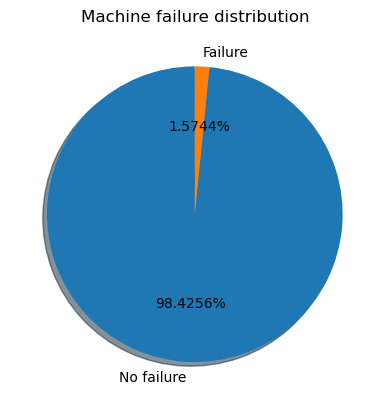

In [6]:
NUM_FAILURES = train_df["Machine failure"].value_counts()[1]
NUM_NO_FAILURES = train_df["Machine failure"].value_counts()[0]

print(f"Number of cases with machine failures: {NUM_FAILURES}\nNumber of cases with no machine failures: {NUM_NO_FAILURES}")

plt.pie([NUM_NO_FAILURES, NUM_FAILURES], labels=["No failure", "Failure"], autopct='%1.4f%%', shadow=True, startangle=90)
plt.title("Machine failure distribution")
plt.show()

In [7]:
from sklearn.model_selection import train_test_split

# naive approach: split the unbalanced dataset into train and test sets

X = train_df.drop(["Machine failure"], axis=1).drop(["Product ID"], axis=1)
y = train_df["Machine failure"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

# advanced: using the Synthetic Minority Over-sampling Technique (SMOTE) to balance the dataset

from imblearn.over_sampling import SMOTE

sm = SMOTE(random_state=42)

X_res, y_res = sm.fit_resample(X, y)

X_train_res, X_test_res, y_train_res, y_test_res = train_test_split(X_res, y_res, test_size=0.2)



In [8]:
from sklearn.ensemble import RandomForestClassifier

# create a random forest classifier
clf = RandomForestClassifier(n_estimators=100)

# train the model using the unbalanced training sets
clf.fit(X_train, y_train)

# predict on the test set
y_pred = clf.predict(X_test)

from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# print the results
print(classification_report(y_test, y_pred))
accuracy_imbalanced_randomForest =  accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy_imbalanced_randomForest}")


              precision    recall  f1-score   support

       False       1.00      1.00      1.00     26866
        True       0.97      0.77      0.86       420

    accuracy                           1.00     27286
   macro avg       0.98      0.88      0.93     27286
weighted avg       1.00      1.00      1.00     27286

Accuracy: 0.9961152239243568


In [13]:
# again, create a random forest classifier

clf = RandomForestClassifier(n_estimators=100)

# train the model using the balanced training sets
clf.fit(X_train_res, y_train_res)

# predict on the test set
y_pred = clf.predict(X_test)

# print the results
print(classification_report(y_test, y_pred))
accuracy_balanced_randomForest =  accuracy_score(y_test, y_pred)

print(f"Accuracy: {accuracy_balanced_randomForest}")


# use the model to predict the test set for submission
X_comp = test_df.drop(["Product ID"], axis=1)



y_comp_pred = clf.predict_proba(X_comp)

submission_df = pd.DataFrame({
    "id": test_df["id"],
    "Machine failure": y_comp_pred[:,1]
})

submission_df.to_csv("./data/submission.csv", index=False, columns=["id", "Machine failure"])



              precision    recall  f1-score   support

       False       1.00      1.00      1.00     26866
        True       0.99      0.97      0.98       420

    accuracy                           1.00     27286
   macro avg       0.99      0.98      0.99     27286
weighted avg       1.00      1.00      1.00     27286

Accuracy: 0.999376969874661


In [ ]:
# lets try a larger number of trees in the forest

clf = RandomForestClassifier(n_estimators=150)

# train the model using the balanced training sets
clf.fit(X_train_res, y_train_res)

# predict on the test set
y_pred = clf.predict(X_test)

# print the results
print(classification_report(y_test, y_pred))
accuracy_balanced_randomForest =  accuracy_score(y_test, y_pred)

print(f"Accuracy: {accuracy_balanced_randomForest}")

In [ ]:
# try a deep neural network approach on unbiased data

from sklearn.neural_network import MLPClassifier

clf = MLPClassifier(hidden_layer_sizes=[100,100], random_state=1, max_iter=300, early_stopping=True).fit(X_train, y_train)

y_pred = clf.predict(X_test)

print(classification_report(y_test, y_pred))
accuracy_balanced_neuralNetwork =  accuracy_score(y_test, y_pred)

print(f"Accuracy: {accuracy_balanced_neuralNetwork}")

In [ ]:
# try a neural network approach with the SMOTE balanced data

clf = MLPClassifier(hidden_layer_sizes=[100], random_state=1, max_iter=300, early_stopping=True).fit(X_train_res, y_train_res)

y_pred = clf.predict(X_test)

print(classification_report(y_test, y_pred))

accuracy_balanced_neuralNetwork =  accuracy_score(y_test, y_pred)

print(f"Accuracy: {accuracy_balanced_neuralNetwork}")